# DA24C005
# Assignment 8

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_circles, make_classification
from matplotlib.colors import ListedColormap
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.datasets import make_moons, make_circles
import matplotlib.colors as colors
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
X, y = make_circles(n_samples=500, noise=0.1, random_state=42, factor=0.2)

##### The dataset given to us has two classes: 1 and 0. We change the 0 label to -1 because calculation of errors and sign of final prediction in Adaboost Algorithm requires class labels to be 1,-1.

In [4]:
y = np.array([-1 if label == 0 else 1 for label in y])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Visualisation of the dataset

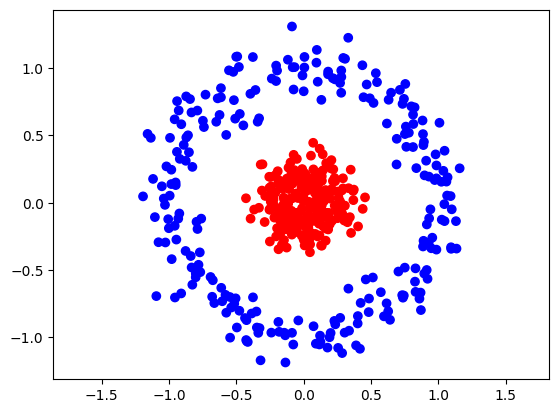

In [6]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=colors.ListedColormap(["blue", "red"]))
plt.axis('equal')
plt.show()

# Task 1:
### - Implementation of `adaboost` algorithm from scratch
### - Implementation of `plot_graph` function which plots graphs of classifier fit at every iteration and the decision boundary of the final ensemble decision boundary

##### This function updates weights of the data-points based on classification errors. If a sample is misclassified, its weight is increased by multiplying it by $e^\alpha$ , making it more important in the next iteration. If the datapoint is correctly classified, its weight is reduced by $e^\alpha$ . After updating the weights, we divide it by sum of weights to normalise it, so that they sum to 1.

In [7]:
def update_weights(w, alpha,y, y_pred, n):
    for i in range(n):
        if y_pred[i] != y[i]:
            w[i] = w[i] * np.exp(alpha)
        else:
            w[i] = w[i] * np.exp(-alpha)
    w = w / np.sum(w)
    return w

##### This function performs weighted sampling with replacement, using the weights vector, `w`. It randomly chooses indices from the dataset X and y based on the probability given by w. It ensures that the misclassified points (which have heigher weights) are more likely to be selected in the next iteration of boosting. Then, it returns the resampled data.

In [8]:
def resampling(w, X, y):
    np.random.seed(42)
    indices = np.random.choice(len(X), size=len(X), replace=True, p=w)
    X, y = X[indices], y[indices]
    return X, y

##### It calculates the weighted classification error for a iteration of boosting. It iterates over each sample, and if the predicted label does not match the true label, the corresponding weight is added to the total error. The function then returns the sum of these weights, which is the weighted error of that classifier for that iteration.

In [9]:
def calculate_error(w, y_pred, n,y):
    error = 0
    for i in range(n):
        if y_pred[i] != y[i]:
         error = error + w[i]
    return error


##### I have created a custom `adaboost` classifier with attributes as, number of iterations, value of eta and the weak classifier to be boosted. The `fit` method trains the weak classifiers iteratively for the given number of iterations. Initially, the sample weights are uniform but after first iteration, sample weights are updated based on the classification errors of the classifier in the previous iteration. The classifiers and their corresponding weights (alpha values) are stored in a list which are used for prediciton. `predict` method combines the predictions of all classifiers according to their weights (alpha values) and then returns the final prediction as the sign of the weighted combination.

In [10]:
class adaboost(BaseEstimator, ClassifierMixin):
    def __init__(self, num_iter = 50, eta=0.5, base_estimator=None):
        self.num_iter = num_iter
        self.eta = eta
        self.alpha_list = []
        self.clsfr_list = []
        self.base_estimator = base_estimator

    def fit(self, X, y):
        n, d = X.shape
        w = np.ones(n) / n
        self.alpha_list = []
        self.clsfr_list = []

        for t in range(self.num_iter):
            clsfr = clone(self.base_estimator)
            try:
                clsfr.fit(X, y, sample_weight=w)
            except TypeError:
                X_t, y_t = resampling(w, X, y)
                if len(np.unique(y_t)) < 2:
                    continue
                clsfr.fit(X_t, y_t)   
            y_pred = clsfr.predict(X)
            error_t = calculate_error(w, y_pred,n,y)
            if error_t >= 0.5:
                alpha = 10**(-3)
            elif error_t <= 0:
                alpha = 4.99
            else:
              alpha = self.eta * np.log((1 - error_t) / error_t)
            w = update_weights(w, alpha, y, y_pred,n)
            self.alpha_list.append(alpha)
            self.clsfr_list.append(clsfr)

    def predict(self, X):
        n = X.shape[0]
        y_pred = np.zeros(n)
        for i in range(len(self.clsfr_list)):
            y_pred = y_pred + self.alpha_list[i] * self.clsfr_list[i].predict(X)
        return np.sign(y_pred)

### `plot_graph` function for visualization:
#### It creates two graphs. The left plot visualizes the fit of the weak classifier at very iteration of the adaboost algorithm. The right plot visualizes the decision boundary of the final ensembled classifier

In [11]:
def plot_graph(adaboost, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    figure, (left_plot, right_plot) = plt.subplots(1, 2, figsize=(14, 8))
    for i in range(len(adaboost.clsfr_list)):
        classifier = adaboost.clsfr_list[i]
        y_pred = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
        y_pred = y_pred.reshape(xx.shape)
        left_plot.contour(xx, yy, y_pred, alpha=0.08, colors='green')
    left_plot.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['red', 'blue']), edgecolor='black')
    left_plot.set_title("Classifier fit at every iteration")
    y_pred = adaboost.predict(np.c_[xx.ravel(), yy.ravel()])
    y_pred = y_pred.reshape(xx.shape)
    right_plot.contourf(xx, yy, y_pred,cmap=ListedColormap(['lightyellow', 'lightgreen']))
    right_plot.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['red', 'blue']), edgecolor='black')
    right_plot.set_title("Decision boundary of the final ensembled classifier")
    plt.tight_layout()
    plt.show()


# Task 2

### - We run our `adaboost` algorithm on the following classifiers: Logistic Regression, Decision Stump, Decision Tree (depth =3), Linear SVM,  LDA

### - We also do hyper-parameter tuning to find best combination of hyper-parameters

### - We also visualise classifier fit at every iteration and the decision boundary of the final ensembled classifier

##### I have created this function to do hyperparameter tuning using grid search. The function takes a `param_grid` parameter, over which it performs grid search. It finds the best combination of parameters, number of iterations, eta value and the corresponding parameters of the weak_classifier.

In [12]:
def hyperparameter_tuning(ada, param_grid, cv = 5):
  gs = GridSearchCV(ada, param_grid, cv=cv)
  gs.fit(X_train, y_train)
  best_params = gs.best_params_
  best_model = gs.best_estimator_
  print("Best Parameters:", best_params)
  return best_model

In [13]:
def calculate_accuracy(clsf):
  ypred_train = clsf.predict(X_train)
  ypred_test = clsf.predict(X_test)
  accuracy_train = np.round((ypred_train==y_train).mean()*100,2)
  accuracy_test = np.round((ypred_test==y_test).mean()*100,2)
  print("Train accuracy:", accuracy_train)
  print("Test accuracy:", accuracy_test)
  return accuracy_train, accuracy_test

### Logisitic Regression

#### Weak classifier - logistic regression

In [14]:
log_reg=LogisticRegression()
log_reg.fit(X_train, y_train)
print("Performance of logistic regression before boosting:")
train_logreg_before, test_logreg_before = calculate_accuracy(log_reg)

Performance of logistic regression before boosting:
Train accuracy: 52.0
Test accuracy: 50.0


#### applying `adaboost` to logistic regression

In [15]:
param_grid = {'eta': [0.2,0.4,0.6,0.8,1], 'num_iter': [50,75,100], 'base_estimator__C': [0.5,0.55,0.6,0.65,0.7],  'base_estimator__solver': ['lbfgs'] }
ada_boost = adaboost(base_estimator=LogisticRegression())
ada_logreg = hyperparameter_tuning(ada_boost, param_grid, cv=5)
print("Performance of logistic regression after boosting:")
train_logreg_after, test_logreg_after = calculate_accuracy(ada_logreg)

Best Parameters: {'base_estimator__C': 0.55, 'base_estimator__solver': 'lbfgs', 'eta': 0.6, 'num_iter': 100}
Performance of logistic regression after boosting:
Train accuracy: 99.43
Test accuracy: 98.67


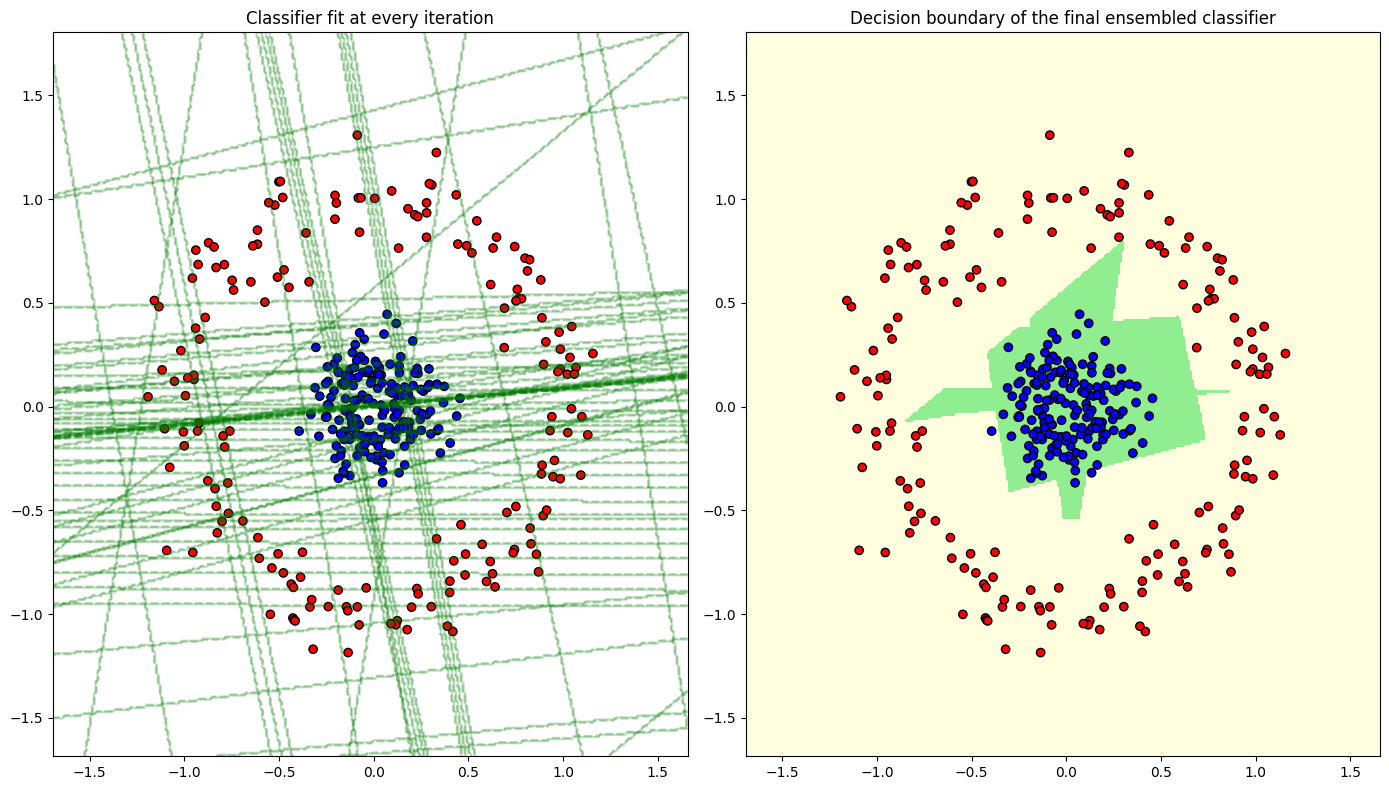

In [16]:
plot_graph(ada_logreg, X_train, y_train)

## Decision Stump

#### Weak classifier - decision stump

In [17]:
dec_stump=DecisionTreeClassifier(max_depth=1)
dec_stump.fit(X_train, y_train)
print("Performance of decision stump before boosting:")
train_stump_before, test_stump_before = calculate_accuracy(dec_stump)

Performance of decision stump before boosting:
Train accuracy: 69.71
Test accuracy: 70.0


#### applying `adaboost` to decision stump

In [18]:
param_grid = {'eta': [0.2, 0.4, 0.6, 0.8, 1], 'num_iter': [50, 75, 100],'base_estimator__min_samples_split': [2, 5, 10],
    'base_estimator__min_samples_leaf': [1, 2, 5],'base_estimator__criterion': ['gini', 'entropy']}
ada_boost = adaboost(base_estimator=DecisionTreeClassifier(max_depth=1))
ada_decstump = hyperparameter_tuning(ada_boost, param_grid)
print("Performance of decision stump after boosting:")
train_stump_after, test_stump_after = calculate_accuracy(ada_decstump)

Best Parameters: {'base_estimator__criterion': 'gini', 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'eta': 0.2, 'num_iter': 50}
Performance of decision stump after boosting:
Train accuracy: 100.0
Test accuracy: 99.33


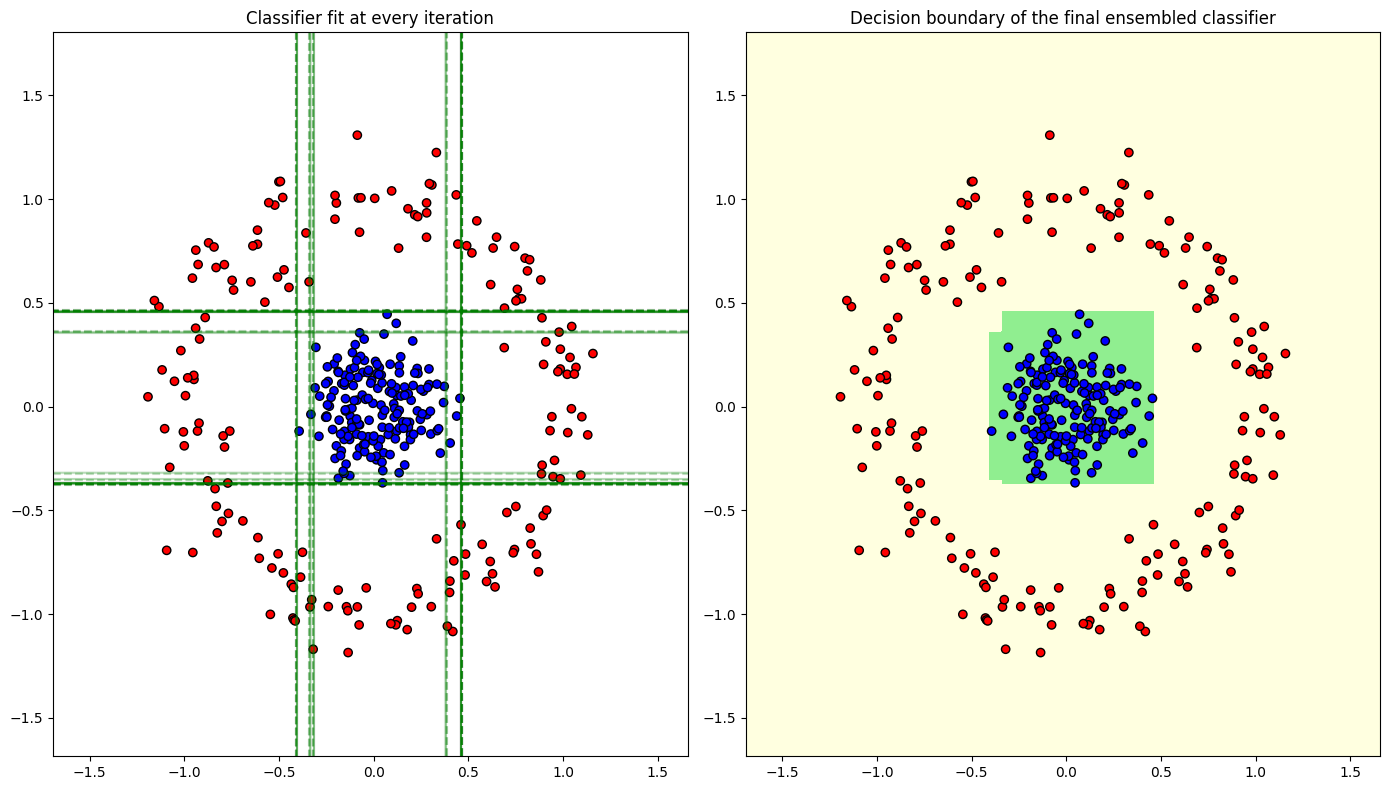

In [19]:
plot_graph(ada_decstump, X_train,y_train)

# Decision tree (depth = 3)

#### weak learner - decision tree (depth =3)

In [20]:
dec_tree=DecisionTreeClassifier(max_depth=3)
dec_tree.fit(X_train, y_train)
print("Performance of decision tree (depth =3) before boosting:")
train_dectree_before, test_dectree_before = calculate_accuracy(dec_tree)

Performance of decision tree (depth =3) before boosting:
Train accuracy: 93.71
Test accuracy: 91.33


#### applying `adaboost` to decision tree (depth = 3)

In [21]:
param_grid = {'eta': [0.2, 0.4, 0.6, 0.8, 1], 'num_iter': [50, 75,100], 'base_estimator__min_samples_split': [2, 5, 10],
    'base_estimator__min_samples_leaf': [1, 2, 5], 'base_estimator__criterion': ['gini', 'entropy']}
ada_boost = adaboost(base_estimator=DecisionTreeClassifier(max_depth=3))
ada_dectree = hyperparameter_tuning(ada_boost, param_grid)
print("Performance of decision tree (depth =3) after boosting:")
train_dectree_after, test_dectree_after = calculate_accuracy(ada_dectree)

Best Parameters: {'base_estimator__criterion': 'entropy', 'base_estimator__min_samples_leaf': 5, 'base_estimator__min_samples_split': 2, 'eta': 0.8, 'num_iter': 100}
Performance of decision tree (depth =3) after boosting:
Train accuracy: 100.0
Test accuracy: 100.0


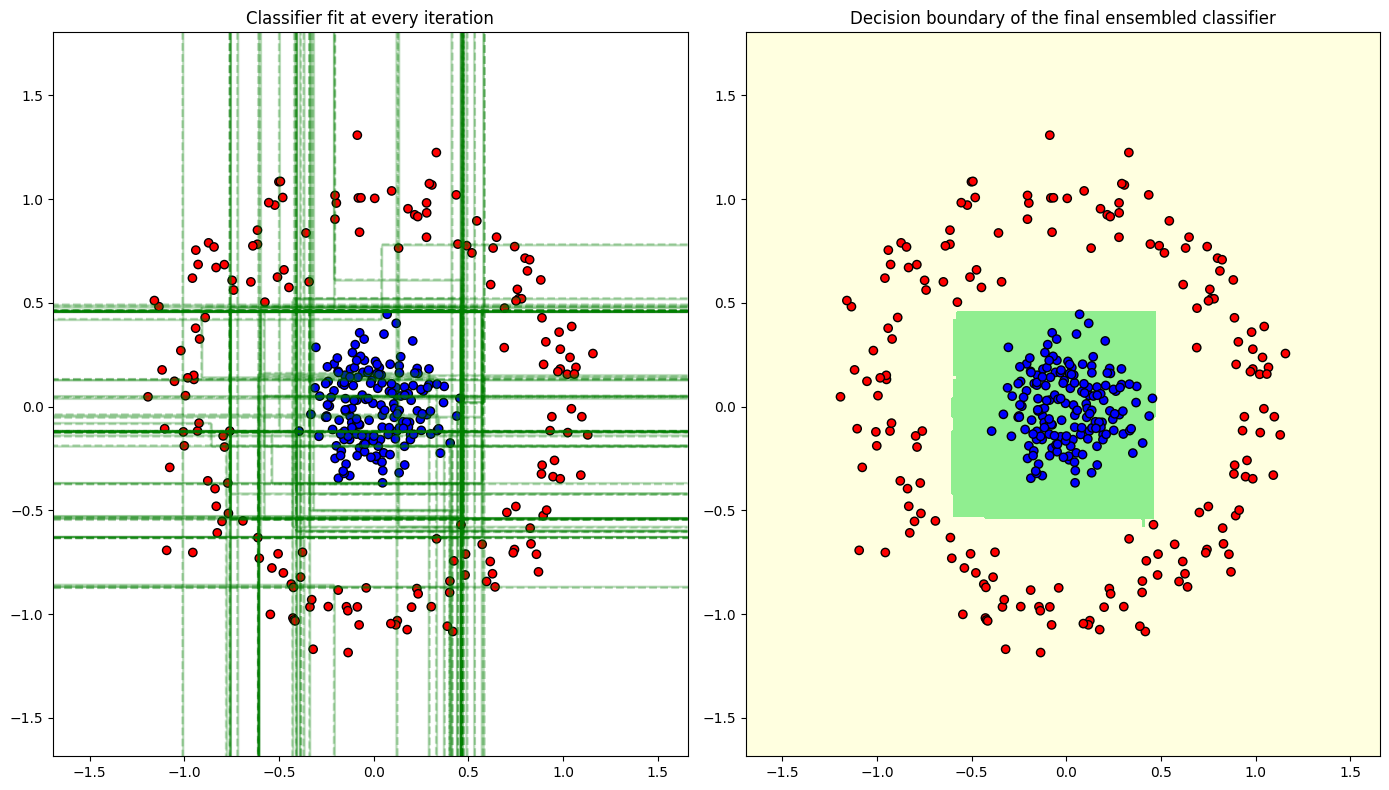

In [22]:
plot_graph(ada_dectree, X_train, y_train)

# Linear SVM

#### weak classfier - linear SVM

In [23]:
linear_svc=LinearSVC()
linear_svc.fit(X_train, y_train)
print("Performance of linear SVC before boosting:")
train_svc_before, test_svc_before = calculate_accuracy(linear_svc)

Performance of linear SVC before boosting:
Train accuracy: 52.0
Test accuracy: 49.33


#### applying `adaboost` to Linear SVM

In [24]:
param_grid = {'eta': np.arange(0.1,1.01,0.2), 'num_iter': [50,75,100],'base_estimator__C': [0.1,1,10,100],
    'base_estimator__penalty':['l1','l2'],'base_estimator__loss': ['hinge']}
ada_boost = adaboost(base_estimator=LinearSVC(random_state=42, max_iter=10000))
ada_svc = hyperparameter_tuning(ada_boost, param_grid)
print("Performance of linear SVC after boosting:")
train_svc_after, test_svc_after = calculate_accuracy(ada_svc)

Best Parameters: {'base_estimator__C': 100, 'base_estimator__loss': 'hinge', 'base_estimator__penalty': 'l2', 'eta': np.float64(0.7000000000000001), 'num_iter': 50}
Performance of linear SVC after boosting:
Train accuracy: 100.0
Test accuracy: 100.0


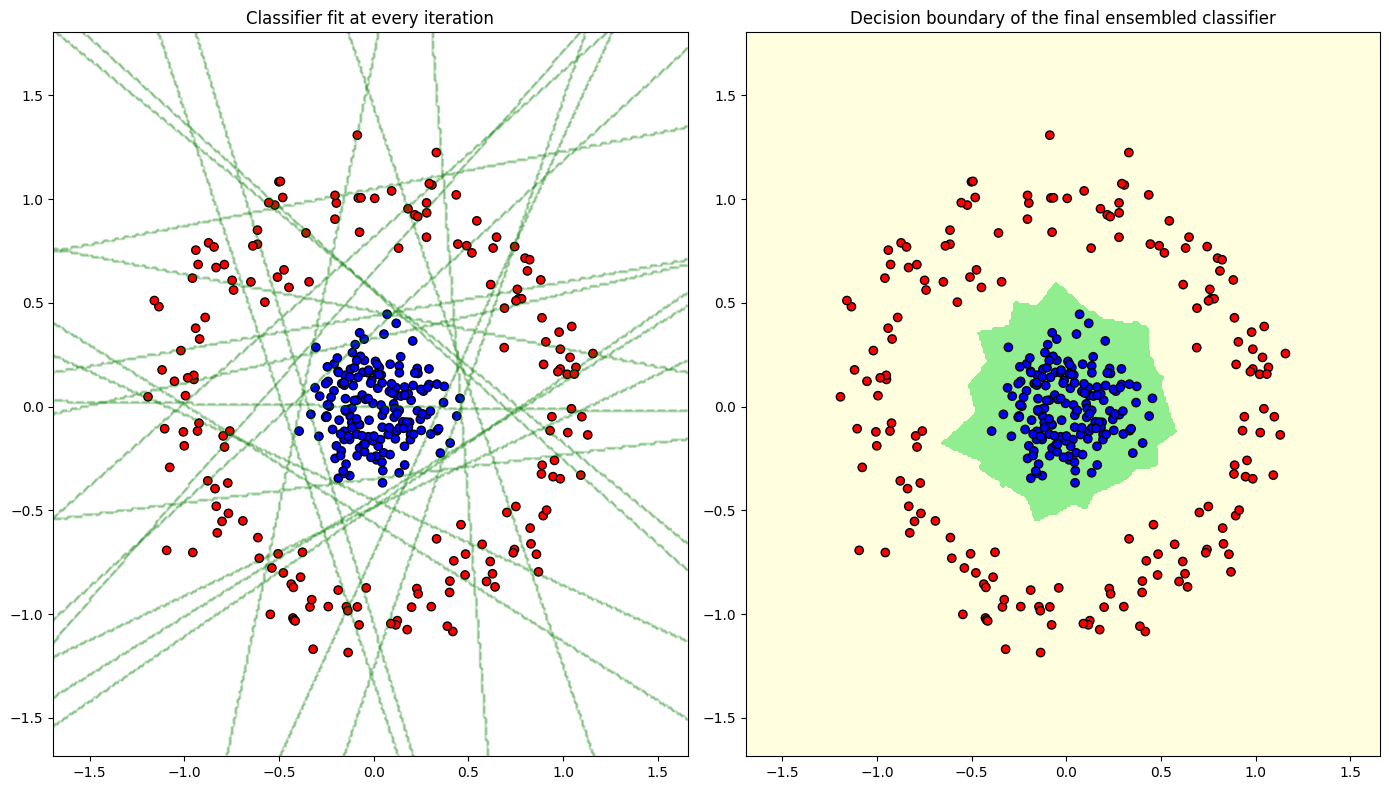

In [25]:
plot_graph(ada_svc, X_train, y_train)

# LDA

#### weak classifier - LDA

In [26]:
lda = LDA()
lda.fit(X_train, y_train)
print("Performance of LDA before boosting:")
train_lda_before, test_lda_before = calculate_accuracy(lda)

Performance of LDA before boosting:
Train accuracy: 52.0
Test accuracy: 49.33


#### Applying `adaboost` to LDA

In [27]:
param_grid = {'eta': [0.71,0.75,8], 'num_iter': [800,900,1000],'base_estimator__solver': ['svd','eigen'],}
ada_boost = adaboost(base_estimator=LDA())
ada_lda = hyperparameter_tuning(ada_boost, param_grid)
print("Performance of LDA after boosting:")
train_lda_after, test_lda_after = calculate_accuracy(ada_lda)

Best Parameters: {'base_estimator__solver': 'svd', 'eta': 0.75, 'num_iter': 900}
Performance of LDA after boosting:
Train accuracy: 99.43
Test accuracy: 98.67


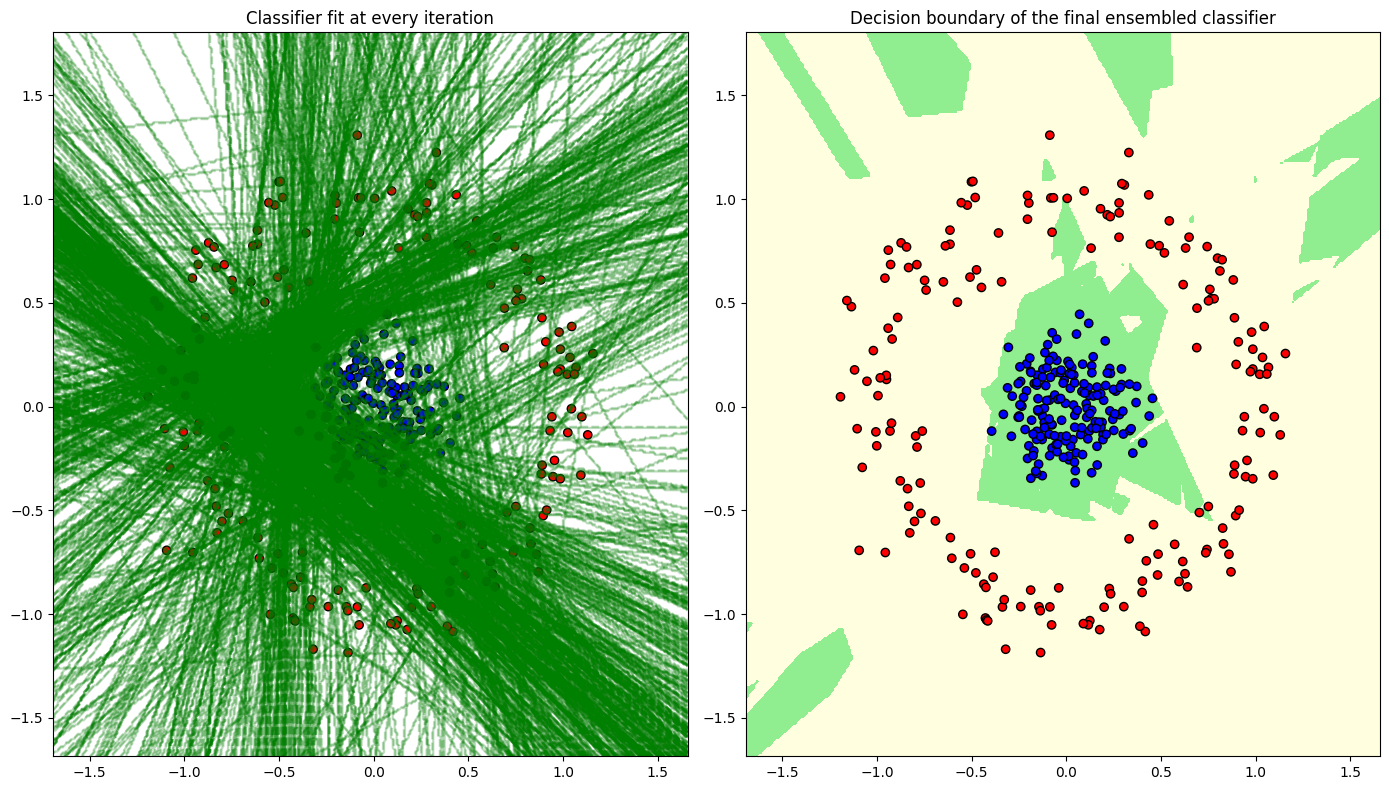

In [28]:
plot_graph(ada_lda, X_train, y_train)

## Summary

In [29]:
classifiers = ['logreg', 'Dec stump', 'Dec Tree', 'Lin SVC', 'LDA']
train_acc_before = [train_svc_before, train_stump_before, train_dectree_before, train_svc_before, train_lda_before] 
test_acc_before = [test_svc_before, test_stump_before, test_dectree_before, test_svc_before, test_lda_before]   
train_acc_after = [train_logreg_after, train_stump_after, train_dectree_after, train_svc_after, train_lda_after]  
test_acc_after = [test_logreg_after, test_stump_after, test_dectree_after, test_svc_after, test_lda_after]  

accuracy_df = pd.DataFrame({
    'Classifier': classifiers,
    'Train (Before)': train_acc_before,
    'Train (After)': train_acc_after,
    'Test (Before)': test_acc_before,
    'Test (After)': test_acc_after
})
print("Train-Test accuracies before and after boosting:")
print(accuracy_df)


Train-Test accuracies before and after boosting:
  Classifier  Train (Before)  Train (After)  Test (Before)  Test (After)
0     logreg           52.00          99.43          49.33         98.67
1  Dec stump           69.71         100.00          70.00         99.33
2   Dec Tree           93.71         100.00          91.33        100.00
3    Lin SVC           52.00         100.00          49.33        100.00
4        LDA           52.00          99.43          49.33         98.67


##### A weak learner is a classifier which performs slightly better than random guessing (50% accuracy). We have taken few classifiers like Logisitic Regression, Decision stump, Decision Tree (depth =3), Linear SVC, LDA. Logisitic regression, Linear SVC and LDA behave as weak learners, whereas Decision stump and decision tree (depth =3) perform relatively well. We boost these weak classifiers into strong learners using `adaboost` algorithm after which they achieve >98% accuracy on train and test data, which is clear from the table above.